In [1]:
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd
from sklearn.model_selection import train_test_split
import sqlite3
import pandas as pd
from pathlib import Path
import os
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, LeakyReLU, Masking
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Bidirectional 

physical_devices = tf.config.list_physical_devices('GPU')

tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)



In [2]:
def training_data():

    dir = '../../SQL_Data/constant_setup'
    files = os.listdir(dir)
    files = [f for f in files if f.endswith('.sqlite3')]

    data = []
    for f in files:
        path = os.path.join(dir, f)
        conn = sqlite3.connect(path)
        if os.path.getsize(path) > 10000:
            cur = conn.cursor()
            cur.execute('SELECT * FROM TrainingData')
            df = pd.DataFrame(cur.fetchall())
            data.append(df)

    names = list(map(lambda x: x[0], cur.description))
    df = pd.concat(data)
    df.columns = names
    df = df.drop(['frameIdentifier','bestLapTime', 'pkt_id', 'packetId', 'SessionTime', 'finalLapTime'], axis=1)
    df.set_index('index', inplace=True)

    return df

In [3]:
def pad_data(training, target):
    
    max_timesteps = 10000 # max(training, key=len).shape[0]
    num_rows_to_add = [max_timesteps-l.shape[0] for l in training]
    training_pad = []
    target_pad = []
    print(f'max timesteps : {max_timesteps}')
    
    for i in range(len(training)):
        rows_to_add = num_rows_to_add[i]

        training_arr = training[i]
        training_append = np.zeros((rows_to_add, training[0].shape[1]), dtype=float)
        training_array = np.vstack((training_arr, training_append))
        training_pad.append(training_array)

        target_arr = target[i].reshape(target[i].shape[0])
        target_append = np.zeros((rows_to_add), dtype=float)
        target_array = np.concatenate([target_arr, np.zeros(rows_to_add)])
        target_pad.append(target_array)
    
    return training_pad, target_pad

In [4]:
def scale_data(data):
    scalers = {}
    sessionUIDs = data.pop('sessionUID')
    lap_number = data.pop('currentLapNum')
    for i in data.columns:
        scaler = MinMaxScaler()
        s = scaler.fit_transform(data[i].values.reshape(-1,1))
        s = np.reshape(s, len(s))
        scalers['scaler_'+ i ] = scaler
        data[i] = s

    data['sessionUID'] = sessionUIDs
    data['currentLapNum'] = lap_number
    
    return data, scalers

In [5]:
def format_data(data):
    '''

    seperates data first by session, then by lap, before padding each array so that
    they are all the same length for model input.
    Performs test train split also

    '''
    data.reset_index(drop=True, inplace=True)

    session_groups = data.groupby('sessionUID')
    training_data = []
    target_data = []
    total_laps = 0
    for s in list(session_groups.groups):
        session = session_groups.get_group(s)
        lap_groups = session.groupby('currentLapNum')
        total_laps += len(lap_groups)
        for l in list(lap_groups.groups):
            lap = lap_groups.get_group(l)
            lap = lap.drop(['sessionUID'], axis=1)
            target_data.append(lap.pop('lap_time_remaining'))
            training_data.append(lap)
            
    training = [x.to_numpy() for x in training_data]
    target = [y.to_numpy() for y in target_data]
    print(f'Total Laps: {total_laps}')

    max_timesteps = 10000 # max(training, key=len).shape[0]
    num_rows_to_add = [max_timesteps-l.shape[0] for l in training]

    training_pad = []
    target_pad = []
    print(f'max timesteps : {max_timesteps}')

    for i in range(len(training)):
        rows_to_add = num_rows_to_add[i]

        training_arr = training[i]
        training_append = np.zeros((rows_to_add, training[0].shape[1]), dtype=float)
        training_array = np.vstack((training_arr, training_append))
        training_pad.append(training_array)

        target_arr = target[i]
        target_append = np.zeros((rows_to_add), dtype=float)
        target_array = np.concatenate([target_arr, np.zeros(rows_to_add)])
        target_pad.append(target_array)

    split = int(total_laps*0.9)

    X_train = training_pad[:split]
    X_test = training_pad[split:]
    y_train = target_pad[:split]
    y_test = target_pad[split:]

    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    y_train = np.array(y_train)

    print('Data Formatted')

    return X_train, X_test, y_train, y_test

In [6]:
def train_model(model, trainX, trainY):
    ''' training the model'''
    EPOCHS = 100
    callback = [EarlyStopping(monitor="loss", patience = 10, mode = 'auto', 
                restore_best_weights=True),
                ModelCheckpoint('generator_lstm.h5')]
    history = model.fit(trainX, trainY, callbacks=callback, shuffle=False, epochs=EPOCHS, batch_size=1)
    return history, model

In [10]:
def build_model(trainX):

    ''' buils model and prints out summary'''
    
    learning_rate = 0.001
    units = 128
    epochs = 100
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, LSTM, Dropout, LeakyReLU
    from tensorflow.keras.callbacks import EarlyStopping

    model = Sequential()
    model.add(Bidirectional(LSTM(units, return_sequences=True, input_shape=(None, trainX.shape[2]) )))
    model.add(LeakyReLU(alpha=0.5))
    model.add(Dropout(0.1))
    model.add(Bidirectional(LSTM(units, return_sequences=True)))
    model.add(LeakyReLU(alpha=0.5))
    model.add(Dropout(0.1))
    model.add(Dense(1))

    adam = tf.keras.optimizers.Adam(lr=learning_rate)

    model.compile(optimizer=adam, loss='mse', metrics=['mae'])

#     print(model.summary())

    print('Model Built')

    return model

In [8]:
data = training_data()

In [11]:
trainX, testX, trainY, testY = format_data(data)



model = build_model(trainX)


Total Laps: 224
max timesteps : 10000
Data Formatted
Model Built


In [12]:
print(trainX.shape)

history, model = train_model(model, trainX, trainY)

(201, 10000, 47)
Epoch 1/100
201/201 [==============================] - 120s 577ms/step - loss: 1279.8293 - mae: 24.0060
Epoch 2/100
201/201 [==============================] - 116s 575ms/step - loss: 248.7210 - mae: 8.9244
Epoch 3/100
201/201 [==============================] - 117s 581ms/step - loss: 77.4478 - mae: 4.6516
Epoch 4/100
201/201 [==============================] - 115s 573ms/step - loss: 35.6113 - mae: 3.2143
Epoch 5/100
201/201 [==============================] - 115s 573ms/step - loss: 23.9205 - mae: 2.7802
Epoch 6/100
201/201 [==============================] - 115s 572ms/step - loss: 18.6964 - mae: 2.4890
Epoch 7/100
201/201 [==============================] - 115s 571ms/step - loss: 14.6855 - mae: 2.2484
Epoch 8/100
201/201 [==============================] - 115s 573ms/step - loss: 12.5341 - mae: 2.1272
Epoch 9/100
201/201 [==============================] - 114s 569ms/step - loss: 10.8629 - mae: 1.9699
Epoch 10/100
201/201 [==============================] - 114s 569ms/ste

In [13]:
predictions = model.predict(testX)
print(predictions.shape)

(23, 10000, 1)


In [31]:
def plot_residuals(testX, testY, pred, data):
    residuals = []
    predictions = pred.reshape(pred.shape[0], pred.shape[1])
#   d = data.drop(['sessionUID', 'lap_time_remaining'], axis=1, inplace=True)
    names = data.columns
    err = testY-predictions
    for i in range(len(predictions)):
        test_X = pd.DataFrame(testX[i], columns = names)
        test_X['predictions'] = predictions[i]
        test_X['residuals'] = err[i] 
        residuals.append(pd.DataFrame(test_X))
    final = pd.concat(residuals)
    return final
test_dataframe = plot_residuals(testX, testY, predictions, data)
print(test_dataframe.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 230000 entries, 0 to 9999
Data columns (total 49 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   lastLapTime                230000 non-null  float64
 1   currentLapTime             230000 non-null  float64
 2   currentLapNum              230000 non-null  float64
 3   lapDistance                230000 non-null  float64
 4   carPosition                230000 non-null  float64
 5   sector                     230000 non-null  float64
 6   worldPositionX             230000 non-null  float64
 7   worldPositionY             230000 non-null  float64
 8   worldPositionZ             230000 non-null  float64
 9   worldVelocityX             230000 non-null  float64
 10  worldVelocityY             230000 non-null  float64
 11  worldVelocityZ             230000 non-null  float64
 12  yaw                        230000 non-null  float64
 13  pitch                      2300

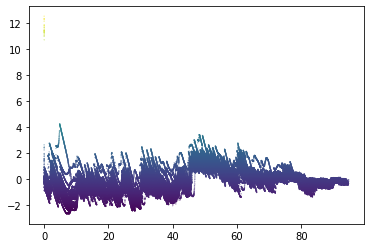

In [41]:
x = test_dataframe['currentLapTime']
y = test_dataframe['residuals']
test_dataframe.to_csv('window_LSTM_predictions.csv')
plt.scatter(x,y, s=0.05, c=y)
plt.show()

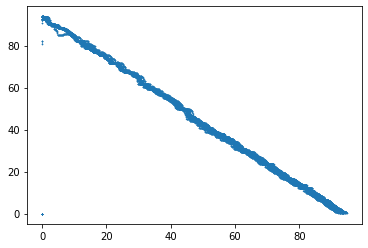

In [43]:
x = test_dataframe['currentLapTime']
y = test_dataframe['predictions']
plt.scatter(x,y, s=0.05,)
plt.show()

In [ ]:
pred = predictions.reshape(predictions.shape[0],predictions.shape[1])
print(pred.shape)

In [ ]:
print(testY.shape)
from IPython.core.pylabtools import figsize

err = pred-testY
plt.figure(figsize(15,12))

for i in pred:
    plt.plot(i)
    
plt.show()

In [ ]:
plt.figure(figsize(15,12))

for i in err:
    plt.plot(i)
    
plt.show()

In [ ]:
# pred = predictions.reshape(predictions.shape[0],predictions.shape[1])
# pred = pred.T
# predictions_df = pd.DataFrame(pred)
print(pred[0].shape)
X_test_0_df = pd.DataFrame(X_test[1])
data_cols = data.columns
cols = data_cols.drop(['sessionUID','lap_time_remaining'])
X_test_0_df.columns = cols
X_test_0_df['predictions'] = pred[1]
X_test_0_df['true'] = y_test[1]
X_test_0_df.head()

x1 = X_test_0_df['predictions'] 
x2 = X_test_0_df['true'] 
x3 = X_test_0_df['sector']
x4 = x2-x1

# plt.plot(x1)
# plt.plot(x2)
plt.plot(x4)
plt.show()

In [ ]:
%matplotlib inline
from IPython.core.pylabtools import figsize

p = pred
y = y_test-p
labels=[]
plt.figure(figsize(15,12))
for i in range(len(y)):
    x = x_test[i]
    plt.scatter(x = x[:, 1], y=y[i], s=2)
    labels.append(i)

plt.title('Estimation Error Throughout Lap')
plt.xlabel('Lap Time')
plt.ylabel('Error (s)')
plt.legend(labels, loc='upper right')
plt.savefig("diff.svg")
plt.show()



In [ ]:
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss',], loc='upper left')
plt.show()

In [ ]:
err = []
from sklearn.metrics import mean_absolute_error as mae
for i in range(len(predictions)): 
    pred_lap = predictions[i]
    true_lap = testY[i]
    err.append(mae(true_lap, pred_lap))

print(f'mean error is {np.mean(err)}')

In [ ]:

for i in range(len(pred)): 
    plt.plot(pred[i])
plt.savefig('predictions.svg')
plt.show()

In [ ]:
df = pd.DataFrame(y.T)
df.info()


In [ ]:
df['mean'] = df.mean(axis=1)
df['std'] = df.std(axis=1)
df['pos_std'] = df['mean']+df['std']
df['neg_std'] = df['mean']-df['std']

fig, ax = plt.subplots()

ax.plot(df['mean'])
ax.fill_between(df.index, df['pos_std'], df['neg_std'], alpha=0.2)